In [1]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import silhouette_score
import seaborn as sns
from pyclustertend import hopkins
import shap
from sklearn.ensemble import IsolationForest
import yellowbrick
from yellowbrick.cluster import KElbowVisualizer

In [2]:
shap.initjs()

In [3]:
def def_outlier(df):
    if (df['y_pred'] in [-1]):
        val = 1
    else:
        val = 0
    return val

# Data

In [26]:
course_name = 'Accountancy'
exam_month = 'januari'
another_month = 'juni'
year = '1819'

In [27]:
data = pd.read_excel(f'./data/{course_name}_{year}_data.xlsx')

In [28]:
data = data.rename(columns = {'ENTROPY_CLICKS':'CONSTANCY_CLICKS',
 'ENTROPY_CLICKS_COURSE_LECTURE_DAILY':'CONSTANCY_CLICKS_COURSE_LECTURE_DAILY',
 'ENTROPY_CLICKS_COURSE_LECTURE_WEEKLY':'CONSTANCY_CLICKS_COURSE_LECTURE_WEEKLY',
 'ENTROPY_SESSION_LENGTH':'CONSTANCY_SESSION_LENGTH', 'LOYALTY_OVERALL':'BINGEING_SESSIONS',
  'DIVERSITY_OVERALL':'UNIFORMITY_SESSIONS', 'REGULARITY':'REGULARITY_SESSIONS'})
data['Passed first attempt?'] = data.apply(lambda x: 1 if x[f'Score {exam_month}'] >= 10 else 0, axis = 1)
data = data.reindex(sorted(data.columns), axis=1)

In [30]:
data = data.rename(columns = {'ACTIVE_DAYS_PROPORTION':'PROPORTION OF ACTIVE DAYS',
                              'ACTIVE_DAYS_PROPORTION_COURSE_LECTURE':'PROPORTION OF ACTIVE DAYS: COURSE MATERIAL',
                              'ACTIVE_DAYS_PROPORTION_COURSE_MAIN_PAGE':'PROPORTION OF ACTIVE DAYS: COURSE MAIN PAGE',
                               'AVERAGE_ACTIONS_PER_SESSION': 'MEDIAN NUMBER OF ACTIONS PER SESSION', 
                               'AVERAGE_ACTIVE_DAYS_PER_WEEK':'MEDIAN NUMBER OF ACTIVE DAYS PER WEEK', 
                               'AVERAGE_SESSION_DURATION':'MEDIAN SESSION DURATION', 
                               'AVG_TIME_DIFF_BETWEEN_ACTIVE_DAYS':'MEDIAN DIFF. BETWEEN ACTIVE DAYS', 
                               'BINGEING_SESSIONS':'BINGEING OF SESSIONS', 
                               'CONSTANCY_CLICKS':'CONSTANCY OF CLICKS',
                               'CONSTANCY_CLICKS_COURSE_LECTURE_DAILY':'CONSTANCY OF CLICKS: COURSE MATERIAL DAILY',
                               'CONSTANCY_CLICKS_COURSE_LECTURE_WEEKLY':'CONSTANCY OF CLICKS: COURSE MATERIAL WEEKLY',
                               'CONSTANCY_SESSION_LENGTH':'CONSTANCY OF SESSION LENGTH',
                               'ENTROPY_CLICKS_COURSE_MAIN_DAILY' : 'CONSTANCY OF CLICKS: COURSE MAIN PAGE DAILY',
                                 'ENTROPY_CLICKS_COURSE_MAIN_WEEKLY' : 'CONSTANCY OF CLICKS: COURSE MAIN PAGE WEEKLY',
                                 'PROPORTION_ACTIVE_WEEKS_COURSE_LECTURE': 'PROPORTION OF ACTIVE WEEKS: COURSE MATERIAL',
                                    'PROPORTION_ACTIVE_WEEKS_COURSE_MAIN' : 'PROPORTION OF ACTIVE WEEKS: COURSE MAIN PAGE',
                               'NON_ZERO_SESSION_COUNT':'TOTAL NUMBER OF SESSIONS',
                               'POSTS_CREATED':'TOTAL NUMBER OF CREATED POSTS',
                               'PROPORTION_ACTIVE_WEEKS':'PROPORTION OF ACTIVE WEEKS',
                               'PROPORTION_LA_FIRST_DAY_OF_WEEK':'PROPORTION OF FIRST-DAY-OF-WEEK ACTIVITY', 
                               'PROPORTION_POSTS_READ':'PROPORTION OF POSTS READ',
                               'PROPORTION_WEEKS_FIRST_DAY_ACTIVE':'PROPORTION OF WEEKS WITH FIRST-DAY ACTIVITY',
                               'REGULARITY_SESSIONS':'REGULARITY OF SESSIONS',
                               'TOTAL_SESSION_DURATION':'TOTAL SESSIONS DURATION',
                               'UNIFORMITY_SESSIONS':'UNIFORMITY OF SESSIONS'})

In [31]:
data = data.drop(columns = ['USER_PK1','COURSE_PK1',f'Score {another_month}','Score september','Passed?'])

In [32]:
independent_features = sorted(list(data.columns))

features_to_drop = {'USER_PK1',
 'COURSE_PK1',
 'Score juni',
 'Score januari',
 'Score september',
 'Eindscore (KF)','Passed?', 'ZERO_SESSIONS_COUNT', 'Passed first attempt?',
 'ACTIVE_DAYS_PROPORTION_FORUM_CONTRIBUTION','ENTROPY_FORUM_CONTRIBUTION_DAILY',
  'ENTROPY_FORUM_CONTRIBUTION_WEEKLY','DIVERSITY_EXAM_PERIOD','LOYALTY_EXAM','PROPORTION_ACTIVE_WEEKS_FORUM_CONTRIBUTION'}

independent_features = sorted(list(set(independent_features) - features_to_drop))

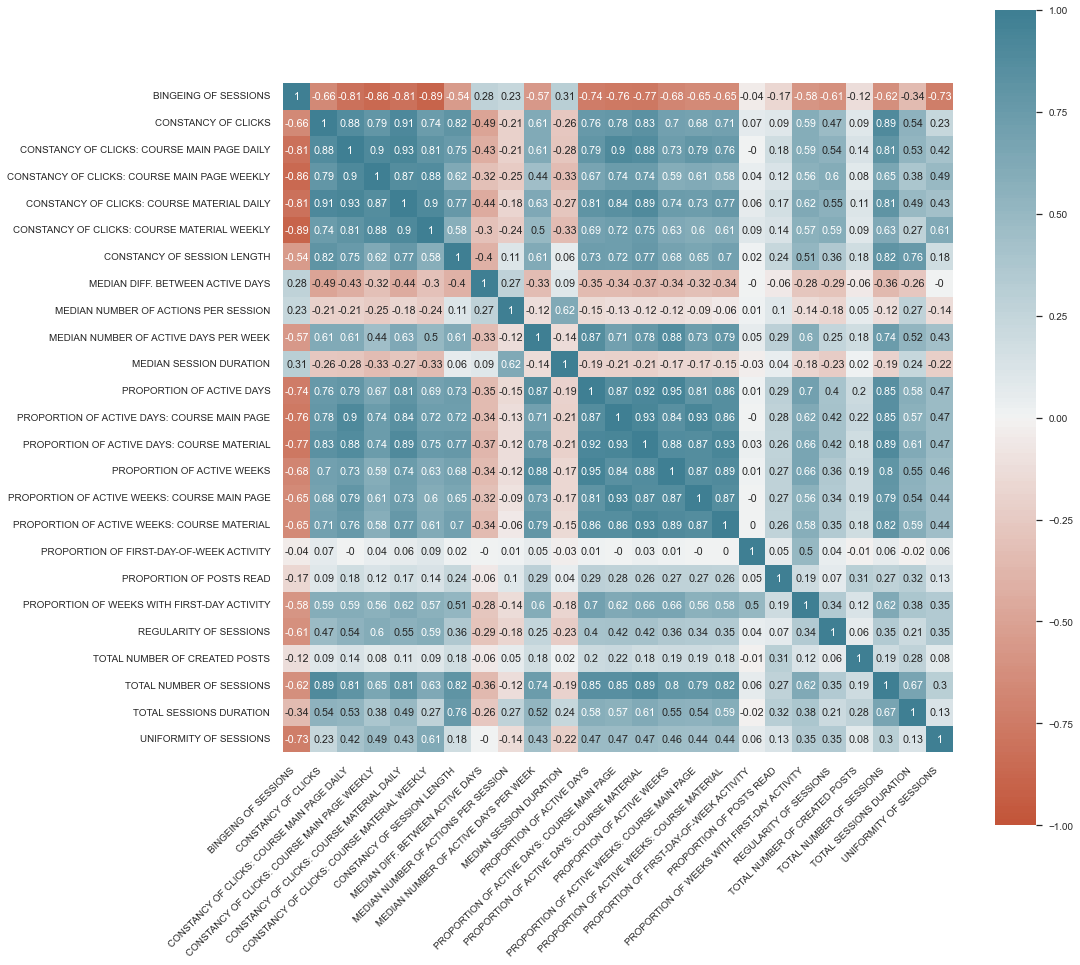

In [33]:
corr = round(data[independent_features].corr(method ='pearson'),2)
sns.set(rc = {'figure.figsize':(15,15)})
sns.set(font_scale=0.9)
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True,
    annot=True
)
ticklabels = ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)

In [35]:
features_to_drop = {'PROPORTION OF ACTIVE DAYS: COURSE MATERIAL',
       'PROPORTION OF ACTIVE DAYS: COURSE MAIN PAGE',

       'CONSTANCY OF CLICKS: COURSE MAIN PAGE DAILY', 
       'CONSTANCY OF CLICKS: COURSE MAIN PAGE WEEKLY',

       'PROPORTION OF ACTIVE WEEKS: COURSE MATERIAL',
       'PROPORTION OF ACTIVE WEEKS: COURSE MAIN PAGE',
       'PROPORTION OF ACTIVE WEEKS',

       'PROPORTION_ACTIVE_WEEKS_FORUM CONTRIBUTION',
       
       'CONSTANCY OF CLICKS: COURSE MATERIAL DAILY',
       'CONSTANCY OF CLICKS: COURSE MATERIAL WEEKLY'}

independent_features = sorted(list(set(independent_features) - features_to_drop))

In [36]:
numerical_features = independent_features

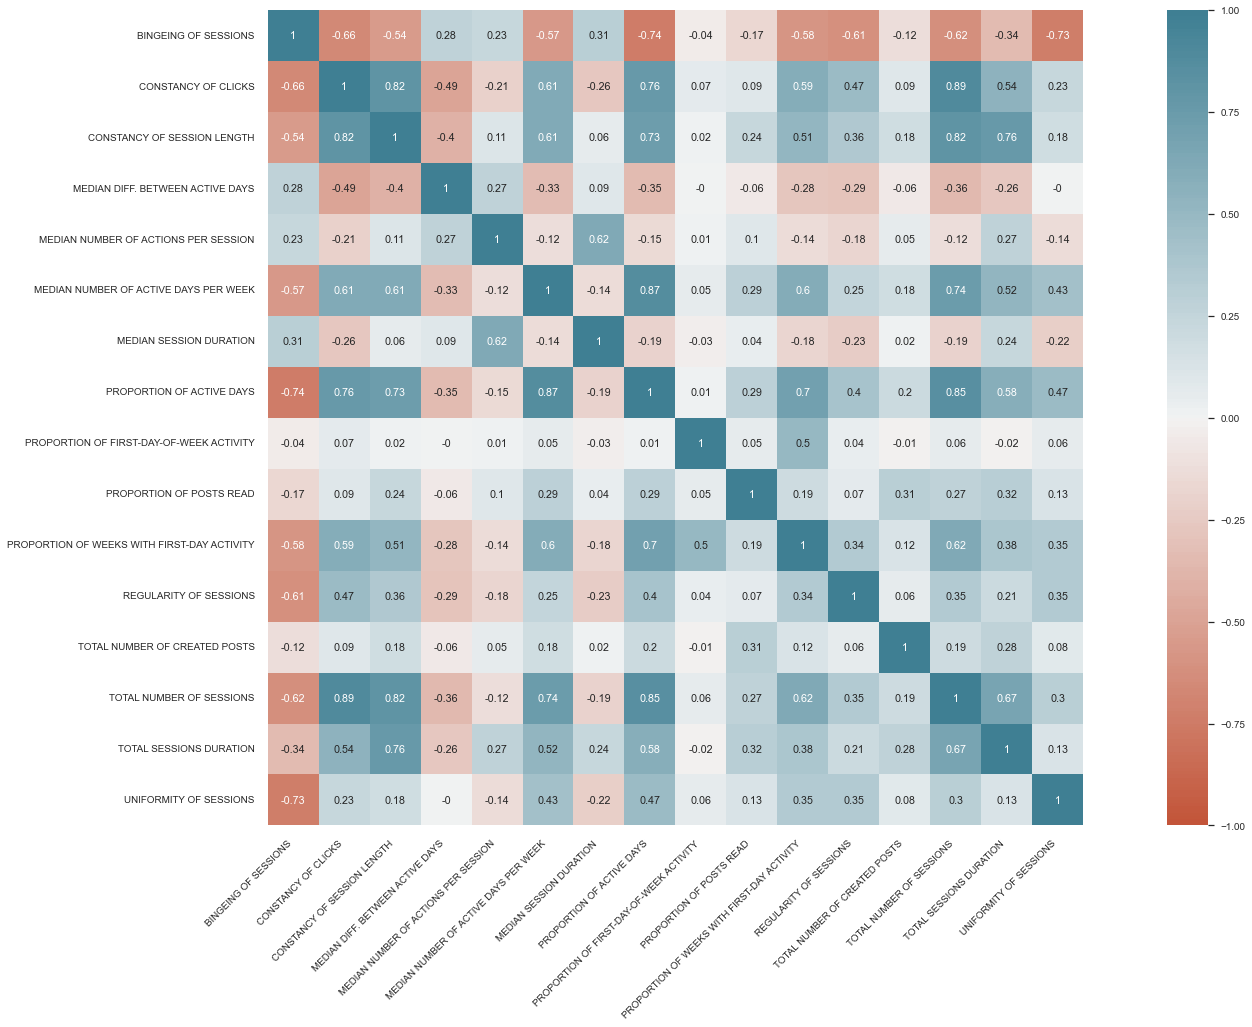

In [37]:
corr = round(data[numerical_features].corr(method ='pearson'),2)
sns.set(rc = {'figure.figsize':(30,15)})
sns.set(font_scale=0.9)
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True,
    annot=True
)
ticklabels = ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)

In [38]:
data = data.dropna(subset=[f'Score {exam_month}'])

In [40]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data[numerical_features])
scaled_data = pd.DataFrame(scaled_data)
scaled_data.columns = numerical_features

# Clustering

In [43]:
hop = hopkins(scaled_data,scaled_data.shape[0])
hop

0.13171202629643353

Text(0.5, 1.0, 'Clustering characteristics')

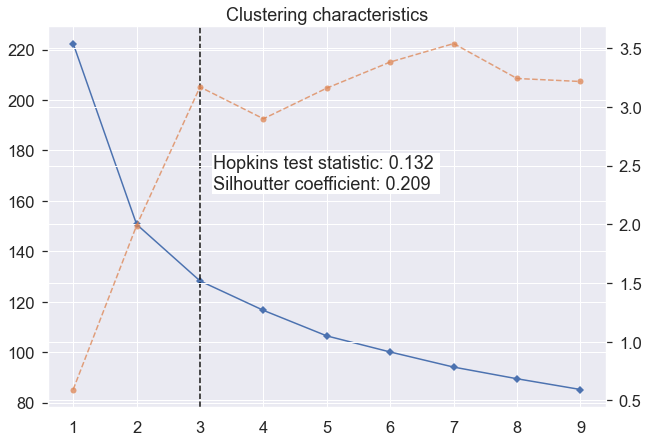

In [44]:
kmeans = KMeans(init="random", n_init=1000, random_state=42)
sns.set(rc={'figure.figsize':(10,7)})
sns.set(font_scale=1.5) 
visualizer = KElbowVisualizer(kmeans, k=(1,10))
visualizer.fit(scaled_data[independent_features])
plt.text(3.2, 2.3, f'Hopkins test statistic: {round(hop,3)} \nSilhoutter coefficient: 0.209', fontsize = 18, bbox={'facecolor':'white','alpha':1,'edgecolor':'none','pad':1})
plt.title('Clustering characteristics')

In [45]:
kmeans = KMeans(
    init="random",
    n_clusters=visualizer.elbow_value_,
    n_init=1000,
    max_iter=300,
    random_state=42
    )
#Fit
kmeans.fit(scaled_data)
labels = kmeans.fit_predict(scaled_data)
data['cluster'] = labels
scaled_data['cluster'] = labels

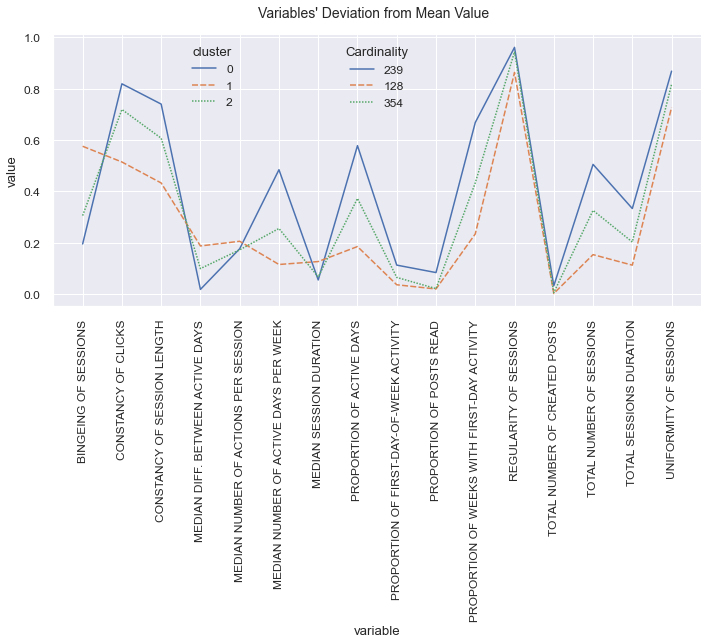

In [46]:
plot = pd.melt(scaled_data, id_vars=['cluster'], value_vars=numerical_features)
sns.set(rc={'figure.figsize':(40,15)})
sns.set(font_scale=1.1) 
g= sns.relplot(x="variable", y="value", hue="cluster", kind="line",
 style="cluster", data=plot,ci=None, height=5, aspect=8/4, palette ="deep")
sns.move_legend(g, "upper left", bbox_to_anchor=(.25, 0.9))
suptitle = g.fig.suptitle("Variables' Deviation from Mean Value", fontsize=14, )
subplots = g.fig.subplots_adjust(top=0.9)
ticks = plt.xticks(rotation=90, fontsize = 12)
plt.legend(pd.pivot_table(data = data.groupby(by = ['cluster']).agg({'cluster':'count'}).rename(columns = {'cluster':
                    'Students'}).reset_index(), index= 'cluster', values='Students').fillna(0)['Students'].values,
title='Cardinality', loc = 'upper center')

In [47]:
score = silhouette_score(scaled_data[numerical_features], labels, metric='euclidean')
# Print the score
print('Silhouetter Score: %.3f' % score)

Silhouetter Score: 0.209


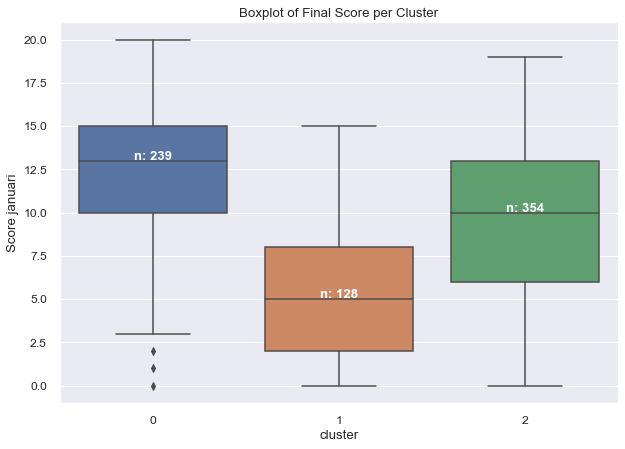

In [48]:
sns.set(rc={'figure.figsize':(10,7)})
sns.set(font_scale=1.1) 
ax = sns.boxplot(x='cluster', y=f'Score {exam_month}', data=data, palette ="deep")
ax.set_title('Boxplot of Final Score per Cluster')
ax.set_ylabel(f"Score {exam_month}")

medians = data.groupby(['cluster'])[f'Score {exam_month}'].median().values
nobs = data.groupby(by = 'cluster').agg({'cluster':'count'})['cluster'].values
nobs = [str(x) for x in nobs.tolist()]
nobs = ["n: " + i for i in nobs]

# Add it to the plot
pos = range(len(nobs))
for tick,label in zip(pos,ax.get_xticklabels()):
    ax.text(pos[tick],
            medians[tick] + 0.07,
            nobs[tick],
            horizontalalignment='center',
            size='medium',
            color='w',
            weight='semibold')

# Anomaly detection

In [49]:
train_data = data[independent_features].copy()
rng = np.random.RandomState(42)
clf = IsolationForest(max_samples=256, n_estimators=100,random_state=rng)
clf.fit(train_data)
y_pred = clf.predict(train_data)
y_scores = -clf.score_samples(train_data)

data['y_pred'] = y_pred
data['y_pred'] = data.apply(def_outlier, axis = 1)

In [50]:
no_anomalies = data[(data['y_pred'] == 0)]
anomalies = data[(data['y_pred'] == 1)]

passing_anomalies = anomalies[anomalies[f'Score {exam_month}'] >= 10]
failing_anomalies = anomalies[anomalies[f'Score {exam_month}'] < 10]
passing_noanomalies = no_anomalies[no_anomalies[f'Score {exam_month}'] >= 10]
failing_noanomalies = no_anomalies[no_anomalies[f'Score {exam_month}'] < 10]

In [51]:
passing_anomalies.shape

(25, 37)

In [52]:
failing_anomalies.shape

(37, 37)

In [53]:
passing_noanomalies.shape

(358, 37)

In [54]:
failing_noanomalies.shape

(301, 37)

# SHAP

In [51]:
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(data[numerical_features])
shaps = explainer(data[numerical_features])

In [53]:
shaps_anomalous_passing_interaction = explainer.shap_interaction_values(passing_anomalies[numerical_features])
shaps_anomalous_failing_interaction =explainer.shap_interaction_values(failing_anomalies[numerical_features])

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


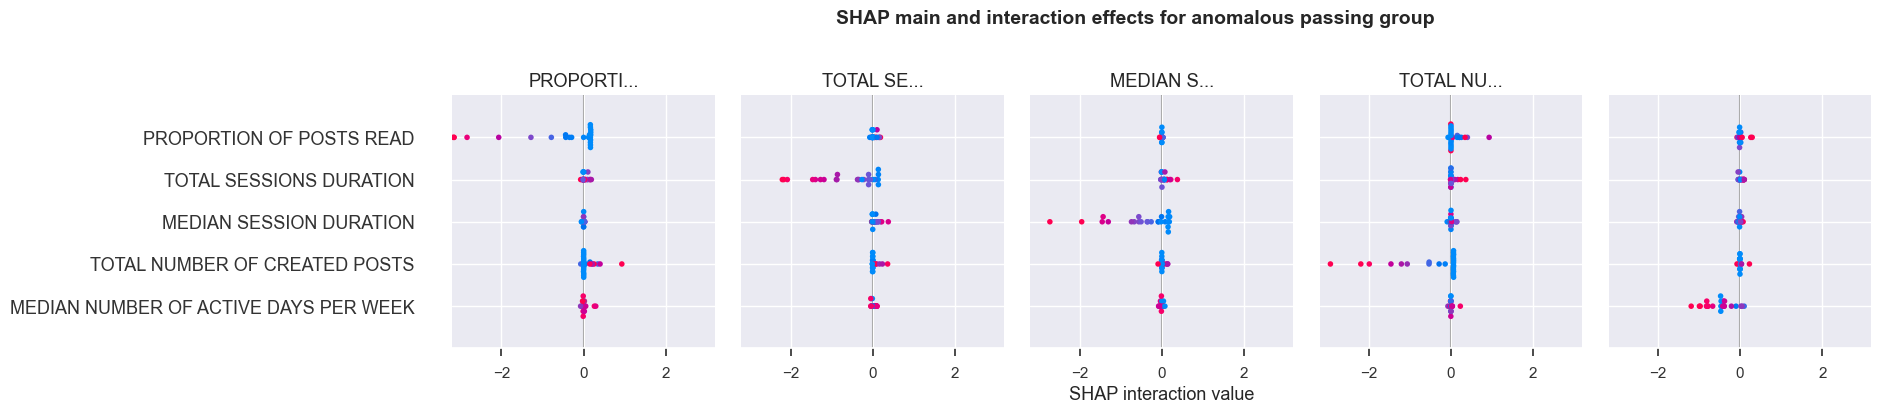

In [54]:
shap.summary_plot(shaps_anomalous_passing_interaction, passing_anomalies[numerical_features], show = False,max_display=5)
plt.gcf().set_size_inches(30,3)
font = {
        'size'   : 8}
plt.title("SHAP main and interaction effects for anomalous passing group", y=1.25,x = -1.8, fontsize = 14, fontweight="bold")
plt.rc('font', **font)

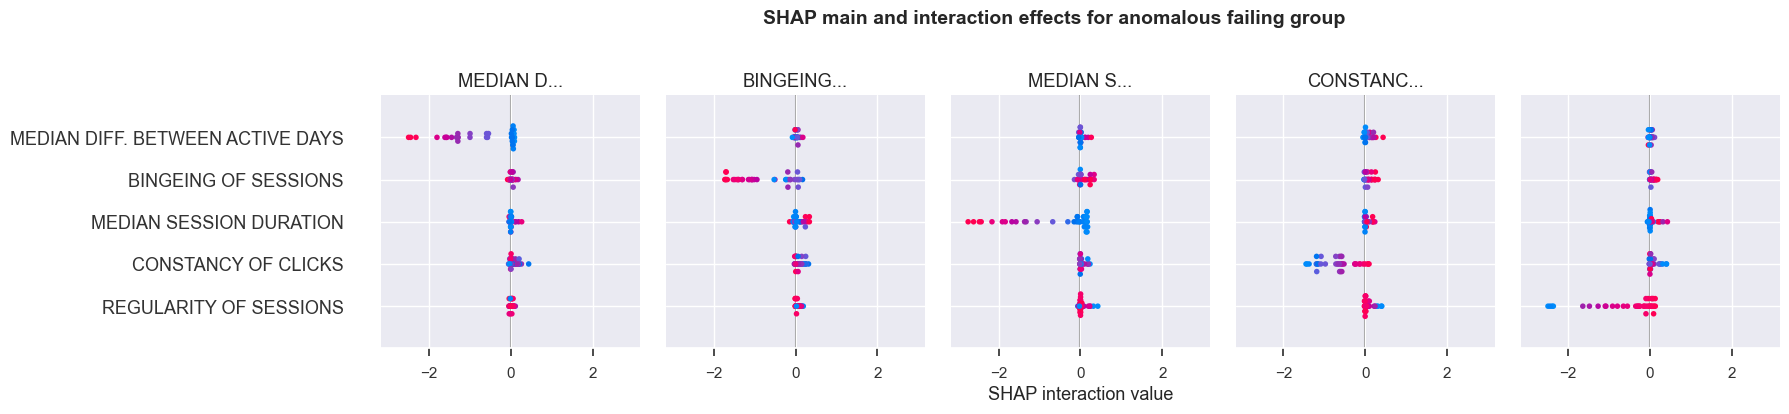

In [55]:
shap.summary_plot(shaps_anomalous_failing_interaction, failing_anomalies[numerical_features], show = False,max_display=5)
plt.gcf().set_size_inches(25,3)
font = {
        'size'   : 8}
plt.title("SHAP main and interaction effects for anomalous failing group", y=1.25,x = -1.8, fontsize = 14, fontweight="bold")
plt.rc('font', **font)